# DoA Estimation using MUSIC and Root-MUSIC

In this notebook we apply subspace-based DoA estimation algorithm, and particularly MUSIC and Root-MUSIC. We demonstrate how they are applied when their underlying assumptions (e.g., non-coherent sources) hold, and what happens when these assumptions are violaited.

##Preparations

To avoid formulating the entire setup, we will clone code available in GitHub for subspace-based DoA estimation, using the syntex below.

In [1]:
!git clone https://github.com/ShlezingerLab/SubspaceNet.git

Cloning into 'SubspaceNet'...
remote: Enumerating objects: 541, done.
remote: Counting objects: 100% (541/541), done.
remote: Compressing objects: 100% (228/228), done.
remote: Total 541 (delta 339), reused 478 (delta 291), pack-reused 0
Receiving objects: 100% (541/541), 5.12 MiB | 23.52 MiB/s, done.
Resolving deltas: 100% (339/339), done.


In [2]:
# Imports
import sys
import torch
import os
import matplotlib.pyplot as plt
import warnings
sys.path.append(r'/content/SubspaceNet')

from src.system_model import SystemModelParams
from src.signal_creation import *
from src.data_handler import *
from src.criterions import set_criterions
from src.training import *
from src.plotting import initialize_figures
from pathlib import Path
from src.models import ModelGenerator

# Initialization
warnings.simplefilter("ignore")
os.system("cls||clear")
plt.close("all")

We export the data paths from the repository

In [3]:
# Initialize paths
external_data_path = Path.cwd() / "SubspaceNet/data"
scenario_data_path = "diff_esprit"
datasets_path = external_data_path / "datasets" / scenario_data_path
saving_path = external_data_path / "weights"

commands = {
    "CREATE_DATA": True,  # Creating new dataset
    "TRAIN_MODEL": True,  # Applying training operation
    "EVALUATE_MODE": True,  # Evaluating desired algorithms
}

# Define system model parameters
system_model_params = (
    SystemModelParams()
    .set_num_sensors(8) # don't touch
    .set_num_sources(3) # M=3
    .set_num_observations(100)
    .set_snr(10) # don't touch
    .set_signal_type("NarrowBand") # don't touch
    .set_signal_nature("non-coherent") # coherent/non-coherent
    .set_sensors_dev(eta=0) # Don't touch
    .set_sv_noise(0) # don't touch
)

model_config = (
    ModelGenerator()
    .set_model_type("SubspaceNet")
    .set_diff_method("root_music")
    .set_tau(8)
    .set_model(system_model_params)
)

set_unified_seed()

##Creating the Data

The imported package allows generating data of the form
\begin{equation}
\boldsymbol{x}_t = \boldsymbol{A}(\boldsymbol{s})\boldsymbol{y}_t + \boldsymbol{w}_t,
\end{equation}
where $\boldsymbol{A}(\boldsymbol{s})$ is the steering matrix for the DoAs in $\boldsymbol{s}$.

We next use this model to generate data stemming from both coherent and non-coherent sources.

In [4]:
# os.system('ln -s {1} {0}'.format(r'/content/data/datasets/diff_esprit/train', r'/content/SubspaceNet/data/datasets/diff_esprit/train'))
# Define samples size
samples_size = 100  # Overall dateset size
train_test_ratio = 1  # training and testing datasets ratio
sig_natures = {'coherent':
               {'train_ds': None, 'test_ds': None, 'test_generic_ds':None, 'sample_model':None},
               'non-coherent':
                {'train_ds': None, 'test_ds': None, 'test_generic_ds':None, 'sample_model':None}}

for sig_nature in sig_natures.keys():
  print("###### Creating {0} dataset ######".format(sig_nature))
  system_model_params.set_signal_nature(sig_nature)


  (sig_natures[sig_nature]['test_ds'],
    sig_natures[sig_nature]['test_generic_ds'],
  sig_natures[sig_nature]['sample_model']) = create_dataset(
      system_model_params=system_model_params,
      samples_size= samples_size,
      model_type=model_config.model_type,
      tau=model_config.tau,
      save_datasets=True,
      datasets_path=datasets_path,
      true_doa=None,
      phase="test",
  )

###### Creating coherent dataset ######


100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


###### Creating non-coherent dataset ######


100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


## Evaluating the Estimators

### RootMUSIC

RootMUSIC operates by casting the subspace equality of a ULA as finding the roots of a polynomial functions, where roots lying on the unit circle correspond to DoAs

In [5]:

import numpy as np
import scipy
import torch
from src.methods import  SubspaceMethod
from src.system_model import SystemModel
from src.utils import sum_of_diag, find_roots, R2D


class RootMUSIC(SubspaceMethod):

    def __init__(self, system_model: SystemModel):

        super().__init__(system_model)

    def narrowband(
        self,
        X: np.ndarray,
        known_num_of_sources: bool = True,
        mode: str = "sample",
        model: SubspaceNet = None,
    ):
        # Whether the number of sources is given
        if known_num_of_sources:
            M = self.system_model.params.M
        else:
            # clustering technique
            pass
        # Calculate covariance matrix
        covariance_mat = self.calculate_covariance(X=X, mode=mode, model=model)
        # Get noise subspace
        Un, _ = self.subspace_separation(covariance_mat=covariance_mat, M=M)
        # Generate hermitian noise subspace matrix
        F = Un @ np.conj(Un).T
        # Calculates the sum of F matrix diagonals
        coefficients = sum_of_diag(F)
        # Calculates the roots of the polynomial defined by F matrix diagonals
        roots = list(find_roots(coefficients))
        # Sort roots by their distance from the unit circle
        roots.sort(key=lambda x: abs(abs(x) - 1))
        # Calculate all predicted angels for spectrum presentation
        doa_predictions_all, roots_angels_all = self.extract_predictions_from_roots(roots)
        # Take only roots which inside the unit circle
        roots_inside = [root for root in roots if ((abs(root) - 1) < 0)][:M]
        # Calculate DoA out of the roots inside the unit circle
        doa_predictions, _ = self.extract_predictions_from_roots(roots_inside)
        return doa_predictions, roots, doa_predictions_all, roots_angels_all, M

    def extract_predictions_from_roots(self, roots: np.ndarray):
        # Calculate the phase component of the roots
        roots_angels = np.angle(roots)
        # Calculate the DoA out of the phase component
        doa_predictions = np.arcsin((1 / np.pi) * roots_angels) * R2D
        return doa_predictions, roots_angels

###MUSIC

MUSIC also originates from the subspace equality, casting a spectrum as the inverse projection of the steering vectors on the noise subspace, and seeking peaks in the spectrum as angles corresponding to impinging sources

In [6]:
class MUSIC(SubspaceMethod):


    def __init__(self, system_model: SystemModel):

        super().__init__(system_model)
        # angle axis for representation of the MUSIC spectrum
        self._angels = np.linspace(-1 * np.pi / 2, np.pi / 2, 360, endpoint=False)

    def spectrum_calculation(
        self, Un: np.ndarray, f: float = 1, array_form: str = "ULA"
    ):
        core_equation = []
        # Run over all angels in grid
        for angle in self._angels:
            # Calculate the steered vector to angle
            a = self.system_model.steering_vec(theta=angle, f=f, array_form=array_form)[
                : Un.shape[0]
            ]
            # Calculate the core equation element
            core_equation.append(np.conj(a).T @ Un @ np.conj(Un).T @ a)
        # Convert core equation to complex np.ndarray form
        core_equation = np.array(core_equation, dtype=complex)
        # MUSIC spectrum as the inverse core equation
        spectrum = 1 / core_equation
        return spectrum, core_equation

    def get_spectrum_peaks(self, spectrum: np.ndarray):

        # Find spectrum peaks
        peaks = list(scipy.signal.find_peaks(spectrum)[0])
        # Sort the peak by their amplitude
        peaks.sort(key=lambda x: spectrum[x], reverse=True)
        return peaks

    def narrowband(
        self,
        X: np.ndarray,
        known_num_of_sources: bool = True,
        mode: str = "sample",
        model: SubspaceNet = None,
    ):

        # Whether the number of sources is given
        if known_num_of_sources:
            M = self.system_model.params.M
        else:
            # clustering technique
            pass
        # Calculate covariance matrix
        covariance_mat = self.calculate_covariance(X=X, mode=mode, model=model)
        # Get noise subspace
        Un, _ = self.subspace_separation(covariance_mat=covariance_mat, M=M)
        # TODO: Check if this condition is hold after the change
        # Assign the frequency for steering vector calculation (multiplied in self.dist to get dist = 1/2)
        f = self.system_model.max_freq[self.system_model.params.signal_type]
        # Generate the MUSIC spectrum
        spectrum, _ = self.spectrum_calculation(Un, f=f)
        # Find spectrum peaks
        doa_predictions = self.get_spectrum_peaks(spectrum)
        # Associate predictions to angels
        predictions = self._angels[doa_predictions] * R2D
        # Take first M predictions
        predictions = predictions[:M][::-1]
        return predictions, spectrum, M

###Evaluate Classic Models

Evaluate model based function

In [7]:
# Imports
import torch.nn as nn
from matplotlib import pyplot as plt

from src.utils import device
from src.criterions import RMSPELoss, MSPELoss
from src.criterions import RMSPE, MSPE
from src.utils import *
from src.plotting import plot_spectrum
from src.evaluation import add_random_predictions

spec_path = 'data/spectrums'
if not os.path.exists(spec_path):
  os.makedirs(spec_path) #TODO Dor, bugfix - should savefig only if SAVE_FIG=False

def evaluate_model_based(
    dataset: list,
    system_model,
    criterion: RMSPE,
    plot_spec=False,
    algorithm: str = "music",
    figures: dict = None,
):
    """
    Evaluate different model-based algorithms on a given dataset.

    Args:
        dataset (list): The evaluation dataset.
        system_model (SystemModel): The system model for the algorithms.
        criterion: The loss criterion for evaluation. Defaults to RMSPE.
        plot_spec (bool): Whether to plot the spectrum for the algorithms. Defaults to False.
        algorithm (str): The algorithm to use (e.g., "music", "mvdr", "esprit", "r-music"). Defaults to "music".
        figures (dict): Dictionary containing figure objects for plotting. Defaults to None.

    Returns:
        float: The average evaluation loss.

    Raises:
        Exception: If the algorithm is not supported.
    """
    # Initialize parameters for evaluation
    loss_list = []
    for i, data in enumerate(dataset):
        X, doa = data
        X = X[0]

        # Root-MUSIC algorithms
        if "r-music" in algorithm:
            root_music = RootMUSIC(system_model)
            # Conventional
            predictions, roots, predictions_all, _, M = root_music.narrowband(
                X=X, mode="sample"
            )
            # If the amount of predictions is less than the amount of sources
            predictions = add_random_predictions(M, predictions, algorithm)
            # Calculate loss criterion
            loss = criterion(predictions, doa * R2D)
            loss_list.append(loss)
            # Plot spectrum
            if plot_spec and i == len(dataset.dataset) - 1:
                plot_spectrum(
                    predictions=predictions_all,
                    true_DOA=doa[0] * R2D,
                    roots=roots,
                    algorithm=algorithm.upper(),
                    figures=figures,
                )
        # MUSIC algorithms
        elif "music" in algorithm:

            music = MUSIC(system_model)

            if algorithm.startswith("music"):
                # Conventional
                predictions, spectrum, M = music.narrowband(X=X, mode="sample")
            # If the amount of predictions is less than the amount of sources
            predictions = add_random_predictions(M, predictions, algorithm)
            # Calculate loss criterion
            loss = criterion(predictions, doa * R2D)
            loss_list.append(loss)
            # Plot spectrum
            if plot_spec and i == len(dataset.dataset) - 1:
                plot_spectrum(
                    predictions=predictions,
                    true_DOA=doa * R2D,
                    system_model=system_model,
                    spectrum=spectrum,
                    algorithm=algorithm.upper(),
                    figures=figures,
                )

        else:
            raise Exception(
                f"evaluate_augmented_model: Algorithm {algorithm} is not supported."
            )
    return np.mean(loss_list)


### Evaluation stage - Coherent vs Non-Coherent

We note that the subspace equality, which lies in the basis of subspace methods such as MUSIC and RootMUSIC, rely on the sources being non-coherent. As we see next, they accurately recover the impinging sources in such cases, while struggle with coherent sources.

Loss measure = rmse
music_coherent test loss = 0.39343503000700486
music_non-coherent test loss = 0.0446841211146277




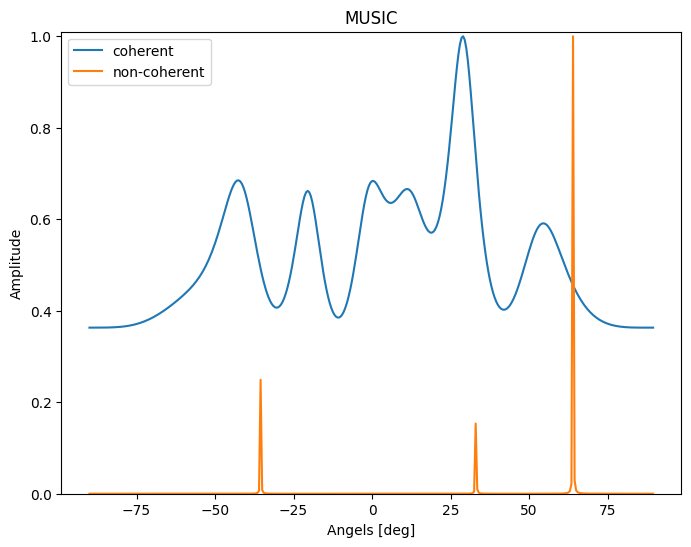

r-music_coherent test loss = 0.39229203535912527
r-music_non-coherent test loss = 0.01491157369998513




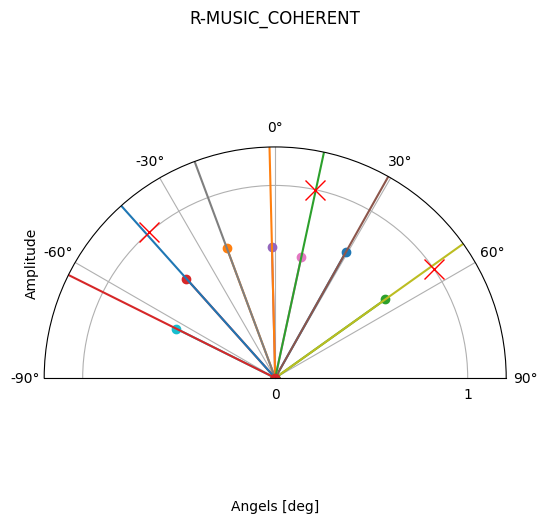

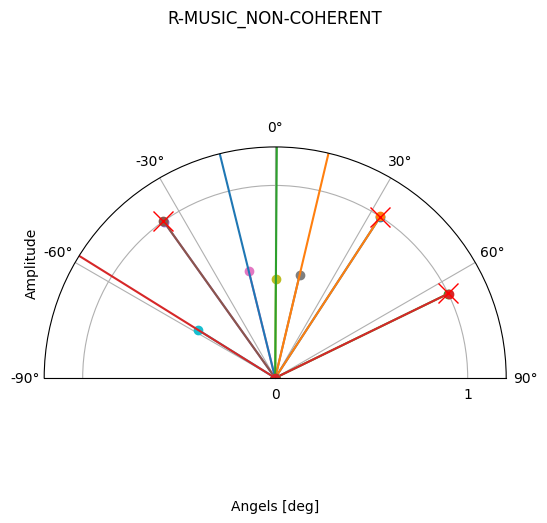

In [8]:
# Initialize figures dict for plotting
figures = initialize_figures()

# Define loss measure for evaluation
criterion, subspace_criterion = set_criterions("rmse")
for algorithm in ["music", "r-music"]:
  # if algorithm=='music':
  #   plt.hold(True)

  for sig_nature in sig_natures.keys():
  # Load datasets for evaluation
    system_model_params.set_signal_nature(sig_nature)

    # Generate DataLoader objects
    model_test_dataset = torch.utils.data.DataLoader(
        sig_natures[sig_nature]['test_ds'], batch_size=1, shuffle=False, drop_last=False
    )
    generic_test_dataset = torch.utils.data.DataLoader(
        sig_natures[sig_nature]['test_generic_ds'], batch_size=1, shuffle=False, drop_last=False
    )


    loss = evaluate_model_based(
        generic_test_dataset,
        system_model=sig_natures[sig_nature]['sample_model'],
        criterion=subspace_criterion,
        plot_spec=True,
        algorithm=algorithm,
        figures=figures,
    )

    sim_name = '{0}_{1}'.format(algorithm, sig_nature)
    print("{} test loss = {}".format(sim_name, loss))
    if algorithm=='r-music':
      plt.title(sim_name.upper())
  if algorithm=='music':
    plt.legend(sig_natures.keys())
    plt.title(algorithm.upper())
  print('\n')

  plt.show()
